MNIST Dataset Support Vector Machine (SVM) by Micah Borghese

The SVM model is a supervised learning model that can be used for both classification and regression problems. The SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall on.

Thoughout this notebook, I'm going to guide in the creation of a SVM learning model to recognize handwritten digits on a 28x28 pixel canvas

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ds, info = tfds.load('mnist', split=None, with_info=True)

C:\Users\micah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now that the dataset is loaded in, we should probably normalize the vector images (make the pixels either a 0 or a 1). This would *probably* help with the model's performance. 

However, I'm going to skip that for now and implement it later. It would also be cool to see how an unnormalized vs normalized dataset would compare in classification accuracy.

In [2]:
training_image_arrays = np.array(list(ds['train'].map(lambda x: x['image']).as_numpy_iterator())) # Convert images to NumPy arrays
training_flatten_images = training_image_arrays.reshape(training_image_arrays.shape[0], -1) # Flatten images (28x28) to 1D vectors of 784 pixels
column_names = [f"pixel_{i}" for i in range(training_flatten_images.shape[1])] # Create a pandas DataFrame
X_train = pd.DataFrame(training_flatten_images, columns=column_names) # x is the independent variable (input) of the model, the vector of features (28x28=784 pixels)
y_train = tfds.as_dataframe(ds['train'].map(lambda x: x['label'])) # y is the dependent variable (output) of the model, the label (0-9)

testing_image_arrays = np.array(list(ds['test'].map(lambda x: x['image']).as_numpy_iterator()))
print(testing_image_arrays.shape)
testing_flatten_images = testing_image_arrays.reshape(testing_image_arrays.shape[0], -1)
print(testing_flatten_images.shape)
column_names = [f"pixel_{i}" for i in range(testing_flatten_images.shape[1])]
X_test = pd.DataFrame(testing_flatten_images, columns=column_names)
y_test = tfds.as_dataframe(ds['test'].map(lambda x: x['label']))

(10000, 28, 28, 1)
(10000, 784)


Using Scikit-Learn's Support Vector Machine (SVM) classification method, I can train a model to classify the images in the MNIST dataset. 

First I'm going to try with the radial basis functions (rbf) kernel, which is a good choice for handling non-linearly seperable feature vectors. It is important to note that the default value of the gamma parameter of rbf is 1/(n_features * X.var()) and the default value of the C parameter is 1.0. Since this will be a non-binary classification (there are 10 classes), I have also set the decision strategy to one-vs-the-rest.

In [3]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
svm = SVC(kernel='rbf', decision_function_shape='ovr', random_state=0)
svm = svm.fit(X_train, y_train) # train the model on the training data and use OneVsRestClassifier to handle multiclass classification

# from svm import SVM
# svm = SVM()
# svm.fit(X_train, y_train)

C:\Users\micah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


After building the SVM, I'm going to save the object in a file using Pickle

In [4]:
import pickle
pickle.dump(svm, open('svm_model.pkl', 'wb'))

Now, I'm going to run the prediction against the test cases from when I partitioned the dataset

In [5]:
y_pred = svm.predict(X_test)

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("Accuracy score:", accuracy_score(y_test, y_pred))

[[ 973    0    1    0    0    2    1    1    2    0]
 [   0 1126    3    1    0    1    1    1    2    0]
 [   6    1 1006    2    1    0    2    7    6    1]
 [   0    0    2  995    0    2    0    5    5    1]
 [   0    0    5    0  961    0    3    0    2   11]
 [   2    0    0    9    0  871    4    1    4    1]
 [   6    2    0    0    2    3  944    0    1    0]
 [   0    6   11    1    1    0    0  996    2   11]
 [   3    0    2    6    3    2    2    3  950    3]
 [   3    4    1    7   10    2    1    7    4  970]]
Precision: 0.9791973966593345
Recall: 0.9790919842945065
Accuracy score: 0.9792


The provided confusion matrix offers a detailed snapshot of a classification model's performance across ten classes (digits 0-9). Notably, the diagonal elements indicate the number of correct predictions for each class. The model achieved high precision in predicting class "1" (with 1126 correct predictions) and class "2" (with 1006 correct predictions). However, off-diagonal elements are areas of misclassification, such as instances where class 1 was mistakenly predicted as class 2 three times. Nonetheless, he matrix illustrates the model's exceptional performance.

Below the confusion matrix is the accuracy score. My model was able to classify grayscale digits in the MNIST dataset at 97.92% accuracy!

Below I'm generating a proof of 5 predictions that my model made with the corrosponding images. Since my model has a high accuracy rate, we should see that most of the predictions and images match to the human eye!

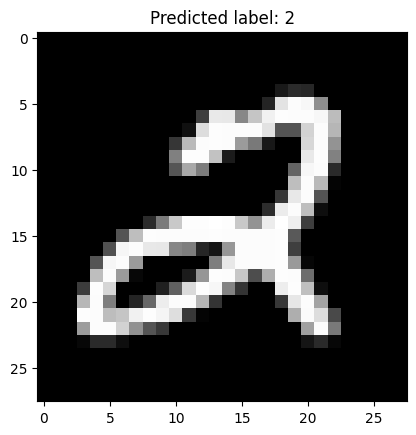

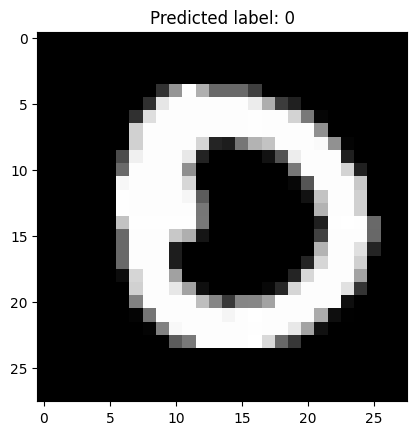

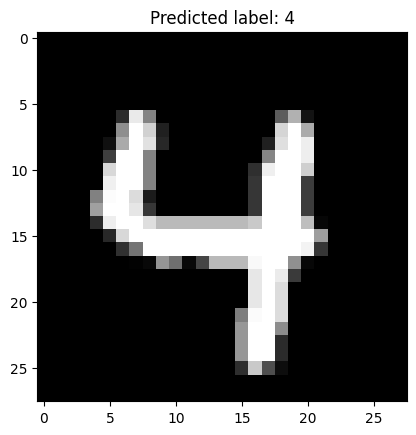

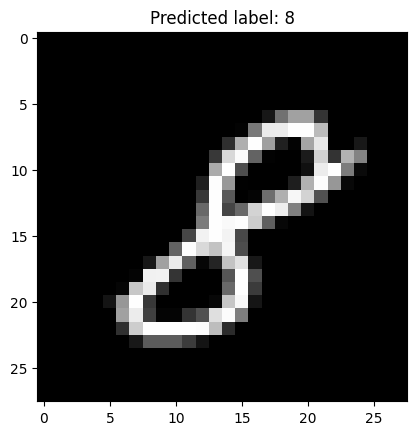

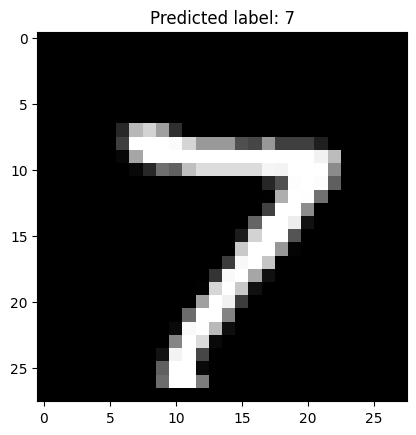

In [7]:
import pickle
svm_model = pickle.load(open('svm_model.pkl', 'rb'))

for i in range(5):
    pixel_data = []
    for j in range(784): # 784 pixels in each image
        pixel_data.append(X_test[f'pixel_{j}'][i])
    pixel_array = np.array(pixel_data, dtype='uint8')
    image_matrix = pixel_array.reshape((28, 28))

    plt.imshow(image_matrix, cmap='gray')  # 'gray' colormap for black and white images
    plt.title(f"Predicted label: {y_pred[i]}")
    plt.show()

In [12]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
svm = SVC(kernel='rbf', C=1.15, gamma=0.2, decision_function_shape='ovr', random_state=0)
svm = svm.fit(X_train, y_train) # train the model on the training data and use OneVsRestClassifier to handle multiclass classification
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("Accuracy score:", accuracy_score(y_test, y_pred))

C:\Users\micah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[ 972    1    0    0    0    0    2    1    3    1]
 [   0 1122    2    1    1    1    2    0    6    0]
 [   4    0 1010    3    1    0    0    7    7    0]
 [   0    0    3  986    0    2    0    5   11    3]
 [   2    0    2    0  956    0    3    1    2   16]
 [   2    0    0   11    0  863    4    1    9    2]
 [   7    2    0    0    2    4  940    0    3    0]
 [   2    5    9    2    2    0    0  998    1    9]
 [   5    1    4    8    5    3    1    4  941    2]
 [   1    6    1   10    8    3    1    5    6  968]]
Precision: 0.9756090351328016
Recall: 0.9753827777035863
Accuracy score: 0.9756


Great! Now, I'm going to do some Normalizing on the original data to see if that affects the accuracy rates...

In [8]:
# change all non-zero values of X_train to 1
X_train[X_train > 0] = 1
# change all non-zero values of X_test to 1
X_test[X_test > 0] = 1

from sklearn.svm import SVC
svm = SVC(kernel='rbf', decision_function_shape='ovr', random_state=0)
svm = svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("Accuracy score:", accuracy_score(y_test, y_pred))


C:\Users\micah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[ 972    1    0    0    0    0    2    1    3    1]
 [   0 1122    2    1    1    1    2    0    6    0]
 [   4    0 1010    3    1    0    0    7    7    0]
 [   0    0    3  986    0    2    0    5   11    3]
 [   2    0    2    0  956    0    3    1    2   16]
 [   2    0    0   11    0  863    4    1    9    2]
 [   7    2    0    0    2    4  940    0    3    0]
 [   2    5    9    2    2    0    0  998    1    9]
 [   5    1    4    8    5    3    1    4  941    2]
 [   1    6    1   10    8    3    1    5    6  968]]
Precision: 0.9756090351328016
Recall: 0.9753827777035863
Accuracy score: 0.9756


It doesn't look like the model did much better as a result.